In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from nnood.self_supervised_task.patch_ex import patch_ex
from nnood.paths import default_data_identifier, preprocessed_data_base, default_plans_identifier
from nnood.utils.file_operations import load_pickle
from nnood.preprocessing.normalisation import denormalise


def wl_to_lh(window, level):
    low = level - window / 2
    high = level + window / 2
    return low,high

def display_image(img, phys_size=None, window=None, level=None, existing_ax=None):

    if window is None:
        window = np.max(img) - np.min(img)

    if level is None:
        level = window / 2 + np.min(img)

    low,high = wl_to_lh(window,level)

    if existing_ax is None:
        # Display the orthogonal slices
        fig, axes = plt.subplots(figsize=(14, 8))
    else:
        axes = existing_ax

    axes.imshow(img, clim=(low, high), extent= None if phys_size is None else (0, phys_size[0], phys_size[1], 0), cmap='gray')

    if existing_ax is None:
        plt.show()
        
def print_stats(arr):
        print(np.mean(arr),', ',np.std(arr))
        print(np.min(arr), '-', np.max(arr))
        print(arr.shape)

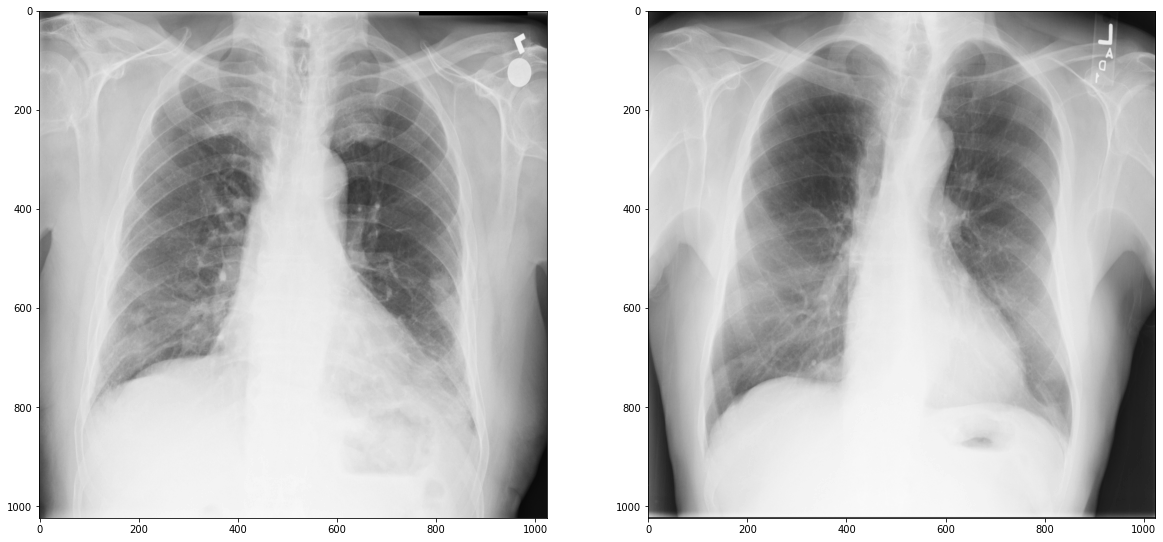

In [2]:

dataset_name = 'chestXray14_PA_male'

test_image_dir = Path(preprocessed_data_base, dataset_name, default_data_identifier + '_stage0')

plans_file = Path(preprocessed_data_base, dataset_name, default_plans_identifier)
plans = load_pickle(plans_file)

male_xray_names = ['00000002_000.npz', '00000006_000.npz']
mvtec_names = ['normal_000.npz', 'normal_001.npz']

test_names = male_xray_names

test_image1 = np.array(np.load(test_image_dir / test_names[0])['data'])
test_image2 = np.array(np.load(test_image_dir / test_names[1])['data'])

test_image1_properties = load_pickle((test_image_dir / test_names[0]).with_suffix('.pkl'))

norm_args = (plans['normalization_schemes'],
             plans['dataset_properties']['intensity_properties'],
             test_image1_properties['channel_intensity_properties'])

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))

display_image(np.moveaxis(denormalise(test_image1, *norm_args), 0, -1), existing_ax=axes[0])
display_image(np.moveaxis(denormalise(test_image2, *norm_args), 0, -1), existing_ax=axes[1])

In [ ]:
from nnood.self_supervised_task.patch_transforms.spatial_transforms import ResizePatch, TranslatePatch
from nnood.self_supervised_task.patch_blender import SwapPatchBlender, UniformPatchBlender,\
    OpenCVPoissonPatchBlender, PoissonPatchBlender
from nnood.self_supervised_task.patch_labeller import BinaryPatchLabeller, ContinuousPatchLabeller,\
    IntensityPatchLabeller, LogisticIntensityPatchLabeller
import cv2

blender = OpenCVPoissonPatchBlender(cv2.NORMAL_CLONE,
                                    (plans['normalization_schemes'],
                                     plans['dataset_properties']['intensity_properties'],
                                     test_image1_properties['channel_intensity_properties']))

patch_img, patch_label, anomaly_locations = patch_ex(test_image1.copy(), test_image2.copy(), patch_transforms=[TranslatePatch()],
                                  blender=blender, labeller=ContinuousPatchLabeller(),
                                  return_anomaly_locations=True, binary_factor=True, num_patches=1)

print('Anomaly locations: ', anomaly_locations)
print_stats(patch_img)
print_stats(patch_label)

fig, axes = plt.subplots(ncols=3, figsize=(30, 10))

display_image(np.moveaxis(denormalise(patch_img, *norm_args), 0, -1), existing_ax=axes[0])
display_image(patch_label[0], existing_ax=axes[1])
axes[2].hist(patch_label[patch_label != 0].flatten(), bins=100)
plt.show()